# This Notebook merges AllDataRetina, Sholl Analysis and Stratification analysis 

In [1]:
import pandas as pd
import os
import glob
import numpy as np
from __future__ import print_function
import pylab as p
from scipy import misc
import sys
from neurom.core.dataformat import COLS
import neurom as nm
from neurom import geom
from neurom.fst import sectionfunc
from neurom.core import Tree
from neurom.core.types import tree_type_checker, NEURITES
from neurom import morphmath as mm
from neurom import viewer
import matplotlib.pyplot as plt
import seaborn as sns

sys.setrecursionlimit(100000)

import pandas as pd
from sklearn.metrics import accuracy_score

In [2]:
os.chdir('/Users/ruff/OneDrive/Retina Python Tools/DataV2')

### Open experiment Dataframe

In [3]:
data=pd.read_excel(os.curdir + '/Alldata_Project_Retina.xlsx', sheetname='CellMorphology')
# Filter Data to experiments performed in year 2017
data=data[data['Year'].isin([2017])]
data['Filename1'] = data['SQL_ID1'] + data['SQL_ID4']
print(data.shape)
data.head(1)

(140, 17)


,Year,Experiment,Sub_Type,Layer,Age,Tamoxifen_ug/g,Genotype,Clone,Typename,Area,Dye,SQL_ID1,SQL_ID2,SQL_ID3,SQL_ID4,SQL_ID5,Filename1
0,2017,14,RGC,GCL,86,20,FLRT3-Cre_Tom+/-,1D5,FLRT3_RBPMS,190.0,Lucifer_Yellow,exp14_17 Pos_R1_1,NaN,Strat,-exported-000edit.swc,rendered Paths,exp14_17 Pos_R1_1-exported-000edit.swc


### Open Sholl Analysis Dataframe
In Sholl analysis circles of increasing radius (10µm) are drawn around the center of a neuron. Then the
number of intersections of the dendritic tree with each circle is counted for each radius. 

In [4]:
sholl = pd.read_csv(os.curdir + '/InData/Sholl/Intersections all neurons.csv')
sholl['Radius'] = sholl['Radius'] + '.swc'
sholl['Filename'] = sholl['Radius']
print(sholl.shape)
sholl.head(1)

(137, 30)


,Radius,sholl0,sholl10,sholl20,sholl30,sholl40,sholl50,sholl60,sholl70,sholl80,...,sholl190,sholl200,sholl210,sholl220,sholl230,sholl240,sholl250,sholl260,sholl270,Filename
0,exp27_17 Pos_R1_14-exported-000edit.swc,1,4,6,14,35,31,34.0,18.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,exp27_17 Pos_R1_14-exported-000edit.swc


### Merge experiment and sholl analysis dataframe based on Filename1 column

In [5]:
df_temp = pd.merge(data,sholl, how='inner', left_on = 'Filename1', right_on = 'Radius')
df_temp.head(1)

,Year,Experiment,Sub_Type,Layer,Age,Tamoxifen_ug/g,Genotype,Clone,Typename,Area,...,sholl190,sholl200,sholl210,sholl220,sholl230,sholl240,sholl250,sholl260,sholl270,Filename
0,2017,14,RGC,GCL,86,20,FLRT3-Cre_Tom+/-,1D5,FLRT3_RBPMS,190.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,exp14_17 Pos_R1_1-exported-000edit.swc


### Generating the stratification dataframe containing the stratification pattern of each cell within the inner plexiform layer

In [6]:
# Function to take series of binary images with the stratification pattern in the inner plexiform layer of each cell

def sec_len(sec):
    '''Return the length of a section'''
    return nm.morphmath.section_length(sec.points)

def StratifyAnalysis (data):
    '''
    Takes Series of images with stratification pattern (binary) and Sums each row, bins into 10, Sums with all other images 
    of same series (=same cell) and plots an image using heatmap
    '''
    
    binnum = 10
    allallstratify = pd.DataFrame()
    for cell in range(len(data)):
        
        images = glob.glob(os.curdir + '/InFigures/' + '*' + data['SQL_ID1'][cell] + ' ' + '*')
        allstratify=pd.DataFrame(columns={'stratify'}, index=np.linspace(0,binnum-1,binnum)).fillna(0)
        for image in images:
            stratify = pd.DataFrame()
            depth = pd.DataFrame()
            stratify = misc.imread(image, flatten = True)
            stratify = pd.DataFrame(np.sum(stratify, axis=1)).iloc[::-1]
            stratify = stratify.reset_index(drop=True)
            stratify = stratify.rename(columns = {0:'stratify'})
            depth = pd.DataFrame(np.linspace(0, 1, len(stratify)))
            depth = depth.rename(columns={0:'depth'})
            stratify['depth']=depth.depth # add depth column to stratify
            stratify.depth=stratify.depth*binnum
            stratify.depth = stratify.depth.astype(int) #convert to integer for subsequent sumation
            stratify['depth'].replace(to_replace=binnum, value=binnum-1, inplace=True, method='pad', axis=None)
            stratify = pd.pivot_table(data=stratify, columns=stratify.depth , aggfunc='sum').transpose()
            allstratify['stratify'] = stratify.stratify + allstratify.stratify
        allstratify = allstratify.stratify/allstratify.stratify.max()#normalize
        allstratify = pd.DataFrame(allstratify) #convert to dataframe
        allstratify = allstratify.transpose()
        #allstratify['SQL_ID1'] = image[12:30]
        allallstratify = pd.concat([allallstratify, allstratify])
    #allallstratify = allallstratify.rename(columns = {0.0:'Layer1',1.0:'Layer2',2.0:'Layer3',3.0:'Layer4',4.0:'Layer5'})
    allallstratify = allallstratify.rename(columns = {0.0:'Layer1',1.0:'Layer2',2.0:'Layer3',3.0:'Layer4',4.0:'Layer5',5.0:'Layer6',6.0:'Layer7',7.0:'Layer8',8.0:'Layer9',9.0:'Layer10'})#Use with 10 layers
    allallstratify = allallstratify.reset_index(drop=True) 
    
    Final_df = pd.DataFrame()                    #Make empty DataFrame for Principle component analysis
    Final_df['SQL_ID1'] = data.loc[:,'SQL_ID1']  #Add Filename SQL_ID in first column
    Final_df['SQL_ID4'] = data.loc[:,'SQL_ID4']
    Final_df = pd.concat([Final_df, allallstratify], axis=1)#Add Stratification
    
    # Neuron Morphology analysis starts here:
    Tracefiles = glob.glob(os.curdir + '/InData/Morphology/*edit.swc') #load all SWC morphology files
    for i in range(len(Final_df)):
        '''check if swc morphology file exists and insert stratification data'''
        Sql1 = Final_df.loc[Final_df.index[i],'SQL_ID1']
        Sql4 = Final_df.loc[Final_df.index[i],'SQL_ID4']
        File = os.curdir + '/InData/Morphology/' +Sql1 + Sql4
        if File in Tracefiles: #Wenn swc File exisitiert
            nrn = nm.load_neuron(File)         
            Final_df.loc[Final_df.index[i],'TotalNeuriteLength']=sum(sec_len(s) for s in nm.iter_sections(nrn))
            #PcaData.loc[PcaData.index[i],'NeuriteSurfaceArea']=sum(nm.morphmath.segment_area(s) for s in nm.iter_segments(nrn))  
            Final_df.loc[Final_df.index[i],'BifurcationPoints']=sum(1 for _ in nm.iter_sections(nrn, iterator_type=Tree.ibifurcation_point))
            Final_df.loc[Final_df.index[i],'Terminations']=nm.get('number_of_terminations', nrn)
             
    return(Final_df)



In [7]:
# Calling Stratification function
stratification = StratifyAnalysis (data)

In [8]:
stratification['Filename'] = stratification['SQL_ID1'] + stratification['SQL_ID4']

### Merge df_temp with Stratification dataframe

In [9]:
df = pd.merge(df_temp,stratification, left_on='Filename', right_on='Filename')
backup = df

## Exploring

#### Do all animals analyzed have the same genotype?

In [10]:
Genotypes = df.Genotype.unique().tolist()
print(Genotypes)
print(len(Genotypes))

['FLRT3-Cre_Tom+/-']
1


--> All animals have the same Genotype 

#### What cell types does the dataset contain?

In [11]:
Celltypes = df.Sub_Type.unique().tolist()
print(Celltypes)
print('The dataset contains ' + str(len(Celltypes)) + ' Cell Types')

['RGC', 'Amacrine', 'RGC?', 'Amacrine?', 'Unknown']
The dataset contains 5 Cell Types


#### How many cells (Sub_Type) in the dataset are RGCs or Amacrines or Unknown?

In [12]:
RGCs = df[df['Sub_Type'].isin(['RGC'])]
Amacrines = df[df['Sub_Type'].isin(['Amacrine'])]
Unknown = df[df['Sub_Type'].isin(['Unknown', 'Amacrine?', 'RGC?'])]

print('Total number of cells = ' + str(len(df)))
print('Number of RGCs = ' + str(len(RGCs)))
print('Number of Amacrines = ' + str(len(Amacrines)))
print('Number of Unknown = ' + str(len(Unknown)))

Total number of cells = 135
Number of RGCs = 89
Number of Amacrines = 27
Number of Unknown = 19


## Clean and preprocess merged dataframe

#### Remove all samples that contain an Unknown Cell Identity in the Sub_Type column

In [13]:
Mask_Unknown=df['Sub_Type'] != 'Unknown'
Mask_Amacrine_Unknown=df['Sub_Type'] != 'Amacrine?'
Mask_RGC_Unknown=df['Sub_Type'] != 'RGC?'

Mask = Mask_Unknown & Mask_Amacrine_Unknown & Mask_RGC_Unknown

df = df[Mask]
print('# of rows removed: ' + str(backup.shape[0] - df.shape[0]))

# of rows removed: 19


#### Encode neuron identity into binary features: RGC=1, Amacrine=0

In [14]:
df['Identity'] = (df['Sub_Type'] == 'RGC')*1
df.head(1)

/Users/ruff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Year,Experiment,Sub_Type,Layer,Age,Tamoxifen_ug/g,Genotype,Clone,Typename,Area,...,Layer5,Layer6,Layer7,Layer8,Layer9,Layer10,TotalNeuriteLength,BifurcationPoints,Terminations,Identity
0,2017,14,RGC,GCL,86,20,FLRT3-Cre_Tom+/-,1D5,FLRT3_RBPMS,190.0,...,0.01392,0.152194,1.0,0.466804,0.021552,0.0,2071.299171,38.0,46.0,1


#### Removing columns that are not needed for neuronal classification (also all containing a string) and replace all NaN of the sholl columns by 0

In [15]:
df = df.drop(['Sub_Type', 'Year','Experiment','Clone','Layer','Tamoxifen_ug/g','Dye','Typename','SQL_ID1_x','SQL_ID2','SQL_ID3','SQL_ID4_x','SQL_ID5','Radius','SQL_ID1_y','SQL_ID4_y', 'Filename','Genotype', 'Filename1'], axis=1)

In [16]:
df.fillna(value=0, inplace=True)
df.columns

Index(['Age', 'Area', ' sholl0', ' sholl10', ' sholl20', ' sholl30',
       ' sholl40', ' sholl50', ' sholl60', ' sholl70', ' sholl80', ' sholl90',
       ' sholl100', ' sholl110', ' sholl120', ' sholl130', ' sholl140',
       ' sholl150', ' sholl160', ' sholl170', ' sholl180', ' sholl190',
       ' sholl200', ' sholl210', ' sholl220', ' sholl230', ' sholl240',
       ' sholl250', ' sholl260', ' sholl270', 'Layer1', 'Layer2', 'Layer3',
       'Layer4', 'Layer5', 'Layer6', 'Layer7', 'Layer8', 'Layer9', 'Layer10',
       'TotalNeuriteLength', 'BifurcationPoints', 'Terminations', 'Identity'],
      dtype='object')

## Exploring II

#### What is the frequency distribution of soma sizes?

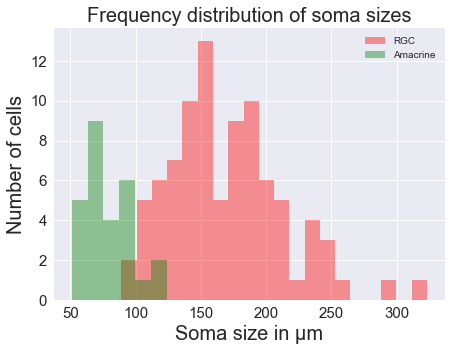

In [17]:
%matplotlib inline
plt.figure(figsize=(7,5))
plt.title('Frequency distribution of soma sizes', size=20)
sns.distplot(RGCs.Area, color = 'r', bins=20,hist=True, label='RGC', kde=False)
sns.distplot(Amacrines.Area,color = 'g', hist=True, label='Amacrine', kde=False)
#sns.distplot(Unknown.Area,color = 'b', bins=20,hist=True, label='Unknown', kde=False)
plt.xlabel('Soma size in µm', size=20)
plt.ylabel('Number of cells', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend()

--> The soma sizes of RGCs are bigger than Amacrines

#### What is the frequency distribution of the total neurite lengths?

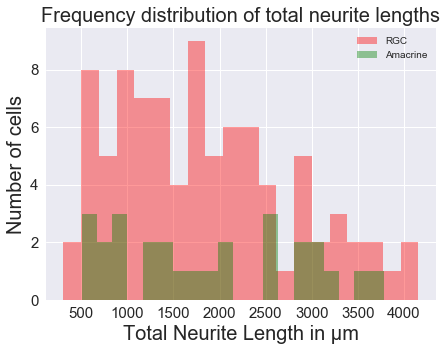

In [18]:
%matplotlib inline
plt.figure(figsize=(7,5))
plt.title('Frequency distribution of total neurite lengths', size=20)
sns.distplot(RGCs.TotalNeuriteLength, color = 'r', bins=20, hist=True, label='RGC', kde=False)
sns.distplot(Amacrines.TotalNeuriteLength, color = 'g', bins=20, hist=True, label='Amacrine', kde=False)

plt.xlabel('Total Neurite Length in µm', size=20)
plt.ylabel('Number of cells', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend()

--> No difference in the total neurite length between RGCs and Amacrines

#### What is the frequency distribution of the total neurite lengths?

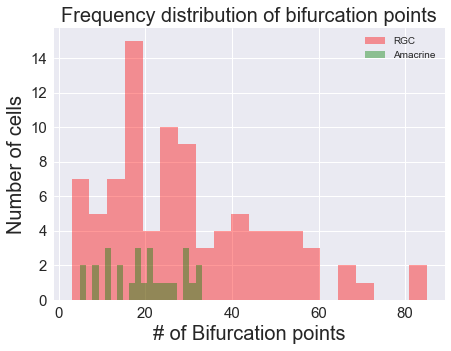

In [19]:
%matplotlib inline
plt.figure(figsize=(7,5))
plt.title('Frequency distribution of bifurcation points', size=20)
sns.distplot(RGCs.BifurcationPoints, color = 'r', bins=20, hist=True, label='RGC', kde=False)
sns.distplot(Amacrines.BifurcationPoints, color = 'g', bins=20, hist=True, label='Amacrine', kde=False)

plt.xlabel('# of Bifurcation points', size=20)
plt.ylabel('Number of cells', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend()

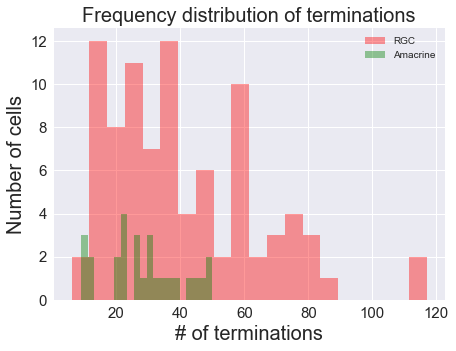

In [20]:
%matplotlib inline
plt.figure(figsize=(7,5))
plt.title('Frequency distribution of terminations', size=20)
sns.distplot(RGCs.Terminations, color = 'r', bins=20, hist=True, label='RGC', kde=False)
sns.distplot(Amacrines.Terminations, color = 'g', bins=20, hist=True, label='Amacrine', kde=False)

plt.xlabel('# of terminations', size=20)
plt.ylabel('Number of cells', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend()

--> It seems that RGCs can have a more complex morphology with more Bifurcations and number of terminations compared to Amacrine cells despite having the same total neurite length

## Preparing

## 1. Which supervised learning algorithm is best suited to predict the cell identity (RGC vs Amacrine) based on morphological criteria: Kernel SVM, Decision Tree classification or Neural network?

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier

### Store Target Identities in Y

In [22]:
Y = df[['Identity']].copy()

### Use morphology features to predict if a cell is an RGC or Amacrine

In [23]:
df.columns

Index(['Age', 'Area', ' sholl0', ' sholl10', ' sholl20', ' sholl30',
       ' sholl40', ' sholl50', ' sholl60', ' sholl70', ' sholl80', ' sholl90',
       ' sholl100', ' sholl110', ' sholl120', ' sholl130', ' sholl140',
       ' sholl150', ' sholl160', ' sholl170', ' sholl180', ' sholl190',
       ' sholl200', ' sholl210', ' sholl220', ' sholl230', ' sholl240',
       ' sholl250', ' sholl260', ' sholl270', 'Layer1', 'Layer2', 'Layer3',
       'Layer4', 'Layer5', 'Layer6', 'Layer7', 'Layer8', 'Layer9', 'Layer10',
       'TotalNeuriteLength', 'BifurcationPoints', 'Terminations', 'Identity'],
      dtype='object')

In [24]:
morphology_features = ['Area', ' sholl0', ' sholl10', ' sholl20', ' sholl30', ' sholl40',
       ' sholl50', ' sholl60', ' sholl70', ' sholl80', ' sholl90', ' sholl100',
       ' sholl110', ' sholl120', ' sholl130', ' sholl140', ' sholl150',
       ' sholl160', ' sholl170', ' sholl180', ' sholl190', ' sholl200',
       ' sholl210', ' sholl220', ' sholl230', ' sholl240', ' sholl250',
       ' sholl260', ' sholl270', 'Layer1', 'Layer2', 'Layer3', 'Layer4',
       'Layer5', 'Layer6', 'Layer7', 'Layer8', 'Layer9', 'Layer10',
       'TotalNeuriteLength', 'BifurcationPoints', 'Terminations']

In [25]:
X = df[morphology_features].copy()

### Perform Test and train split

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=324)
print(len(X_train))
print(len(X_test))

77
39


### Method 1: Fit on Train Set using DecisionTreeClassifier

In [27]:
DecisionTree = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0)
DecisionTree.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=10, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

### Method 2: Fit on Train Set using Support Vector machine

In [28]:
Svm = svm.SVC()
Svm.fit(X_train, Y_train)

/Users/ruff/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Method 3: Fit on Train Set using Neural Networks

In [29]:
NeuralNetwork = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5,2), random_state=1)
NeuralNetwork.fit(X_train, Y_train)

/Users/ruff/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:904: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

### Predict on Test Set using both methods

In [30]:
DecisionTree_prediction = DecisionTree.predict(X_test)
Svm_prediction = Svm.predict(X_test)
NeuralNetwork_prediction = NeuralNetwork.predict(X_test)

print('Accuracy score for DecisionTree is: ' + str(accuracy_score(y_true = Y_test, y_pred = DecisionTree_prediction)))
print('Accuracy score for Svm is: ' + str(accuracy_score(y_true = Y_test, y_pred = Svm_prediction)))
print('Accuracy score for NeuralNetwork is: ' + str(accuracy_score(y_true = Y_test, y_pred = NeuralNetwork_prediction)))

Accuracy score for DecisionTree is: 0.948717948718
Accuracy score for Svm is: 0.794871794872
Accuracy score for NeuralNetwork is: 0.74358974359


In [31]:
Y_test['DecisionTree prediction'] = DecisionTree_prediction
Y_test['Svm prediction'] = Svm_prediction
Y_test['Neural Network prediction'] = NeuralNetwork_prediction

/Users/ruff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/ruff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/ruff/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [32]:
Y_test.head(1)

,Identity,DecisionTree prediction,Svm prediction,Neural Network prediction
46,1,1,1,1


## 2. Are protein X positive RGCs/Amacrines in the retina a homogeneous population?

In [135]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA

from sklearn.decomposition import TruncatedSVD

#### Split RGCs and Amacrines into separate dataframes

In [34]:
RGCs = df[df.Identity == 1]
Amacrines = df[df.Identity == 0]

#### Select the features for PCA and subsequent clustering

In [35]:
df.columns

Index(['Age', 'Area', ' sholl0', ' sholl10', ' sholl20', ' sholl30',
       ' sholl40', ' sholl50', ' sholl60', ' sholl70', ' sholl80', ' sholl90',
       ' sholl100', ' sholl110', ' sholl120', ' sholl130', ' sholl140',
       ' sholl150', ' sholl160', ' sholl170', ' sholl180', ' sholl190',
       ' sholl200', ' sholl210', ' sholl220', ' sholl230', ' sholl240',
       ' sholl250', ' sholl260', ' sholl270', 'Layer1', 'Layer2', 'Layer3',
       'Layer4', 'Layer5', 'Layer6', 'Layer7', 'Layer8', 'Layer9', 'Layer10',
       'TotalNeuriteLength', 'BifurcationPoints', 'Terminations', 'Identity'],
      dtype='object')

In [192]:
feature_strat = ['Layer1', 'Layer2', 'Layer3', 'Layer4', 'Layer5', 'Layer6', 'Layer7', 'Layer8', 'Layer9', 'Layer10']
feature_sholl = [' sholl0', ' sholl10', ' sholl20', ' sholl30',' sholl40', ' sholl50', ' sholl60', ' sholl70', 
                 ' sholl80', ' sholl90',' sholl100', ' sholl110', ' sholl120', ' sholl130', ' sholl140',' sholl150', 
                 ' sholl160', ' sholl170', ' sholl180', ' sholl190',' sholl200', ' sholl210', ' sholl220', ' sholl230',
                 ' sholl240', ' sholl250', ' sholl260', ' sholl270']
feature_all = ['Area', ' sholl0', ' sholl10', ' sholl20', ' sholl30',
       ' sholl40', ' sholl50', ' sholl60', ' sholl70', ' sholl80', ' sholl90',
       ' sholl100', ' sholl110', ' sholl120', ' sholl130', ' sholl140',
       ' sholl150', ' sholl160', ' sholl170', ' sholl180', ' sholl190',
       ' sholl200', ' sholl210', ' sholl220', ' sholl230', ' sholl240',
       ' sholl250', ' sholl260', ' sholl270', 'Layer1', 'Layer2', 'Layer3',
       'Layer4', 'Layer5', 'Layer6', 'Layer7', 'Layer8', 'Layer9', 'Layer10',
       'TotalNeuriteLength', 'BifurcationPoints', 'Terminations']

df_strat = df[feature_strat]
df_sholl = df[feature_sholl]
df_all = df[feature_all]

#### Scale the features

In [195]:
df_strat = StandardScaler().fit_transform(df_strat)
df_sholl = StandardScaler().fit_transform(df_sholl)
df_all = StandardScaler().fit_transform(df_all)

#### Principle component analysis

In [198]:
pca_strat = PCA().fit(df_strat)
pca_sholl = PCA().fit(df_sholl)
pca_all = PCA().fit(df_all)

#### Plot how much each principal component contributes to explain total variance in the data

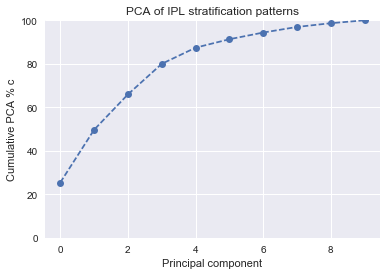

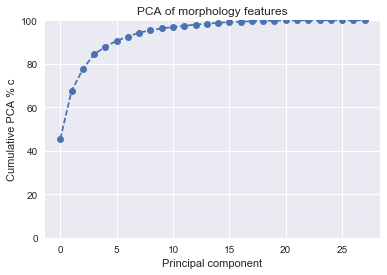

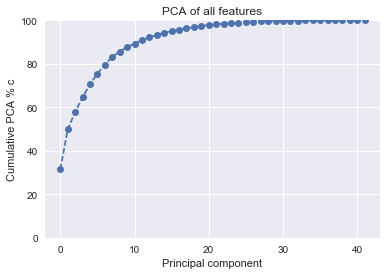

In [199]:
pca_strat_var = pca_strat.explained_variance_ratio_
plt.figure(1)
plt.plot((pca_strat_var*100).cumsum(), '--o')
plt.title('PCA of IPL stratification patterns')
plt.ylim([0,100])
plt.ylabel('Cumulative PCA % c')
plt.xlabel('Principal component')

pca_sholl_var = pca_sholl.explained_variance_ratio_
plt.figure(2)
plt.plot((pca_sholl_var*100).cumsum(), '--o')
plt.title('PCA of morphology features')
plt.ylim([0,100])
plt.ylabel('Cumulative PCA % c')
plt.xlabel('Principal component')

pca_all_var = pca_all.explained_variance_ratio_
plt.figure(3)
plt.plot((pca_all_var*100).cumsum(), '--o')
plt.title('PCA of all features')
plt.ylim([0,100])
plt.ylabel('Cumulative PCA % c')
plt.xlabel('Principal component')

#### Get the first 2 Principal components to visualize them for each sample in a 2D plot

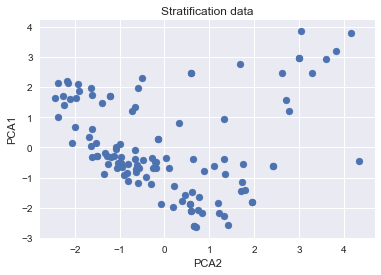

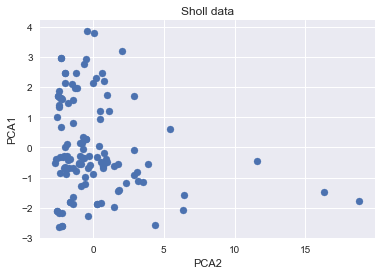

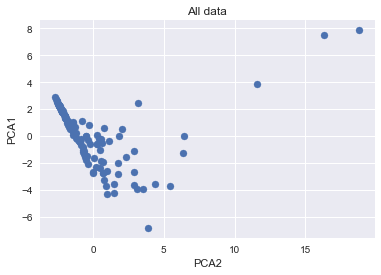

In [206]:
pca_strat_plot = PCA(n_components=2).fit_transform(df_strat)
plt.figure(1)
plt.scatter(pca_strat_plot[:,0],pca_strat_plot[:,1])
plt.title('Stratification data')
plt.xlabel('PCA2')
plt.ylabel('PCA1')

pca_sholl_plot = PCA(n_components=2).fit_transform(df_sholl)
plt.figure(2)
plt.scatter(pca_sholl_plot[:,0],pca_strat_plot[:,1])
plt.title('Sholl data')
plt.xlabel('PCA2')
plt.ylabel('PCA1')

pca_all_plot = PCA(n_components=2).fit_transform(df_all)
plt.figure(3)
plt.scatter(pca_sholl_plot[:,0],pca_sholl_plot[:,1])
plt.title('All data')
plt.xlabel('PCA2')
plt.ylabel('PCA1')

In [126]:
pca_strat

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

### k-Means Clustering

####  Hierarchical clustering algorithm to detect subgroups

In [213]:
Cluster = linkage(df, 'median')

(array([   5,   15,   25,   35,   45,   55,   65,   75,   85,   95,  105,
         115,  125,  135,  145,  155,  165,  175,  185,  195,  205,  215,
         225,  235,  245,  255,  265,  275,  285,  295,  305,  315,  325,
         335,  345,  355,  365,  375,  385,  395,  405,  415,  425,  435,
         445,  455,  465,  475,  485,  495,  505,  515,  525,  535,  545,
         555,  565,  575,  585,  595,  605,  615,  625,  635,  645,  655,
         665,  675,  685,  695,  705,  715,  725,  735,  745,  755,  765,
         775,  785,  795,  805,  815,  825,  835,  845,  855,  865,  875,
         885,  895,  905,  915,  925,  935,  945,  955,  965,  975,  985,
         995, 1005, 1015, 1025, 1035, 1045, 1055, 1065, 1075, 1085, 1095,
        1105, 1115, 1125, 1135, 1145, 1155]),
 <a list of 116 Text xticklabel objects>)

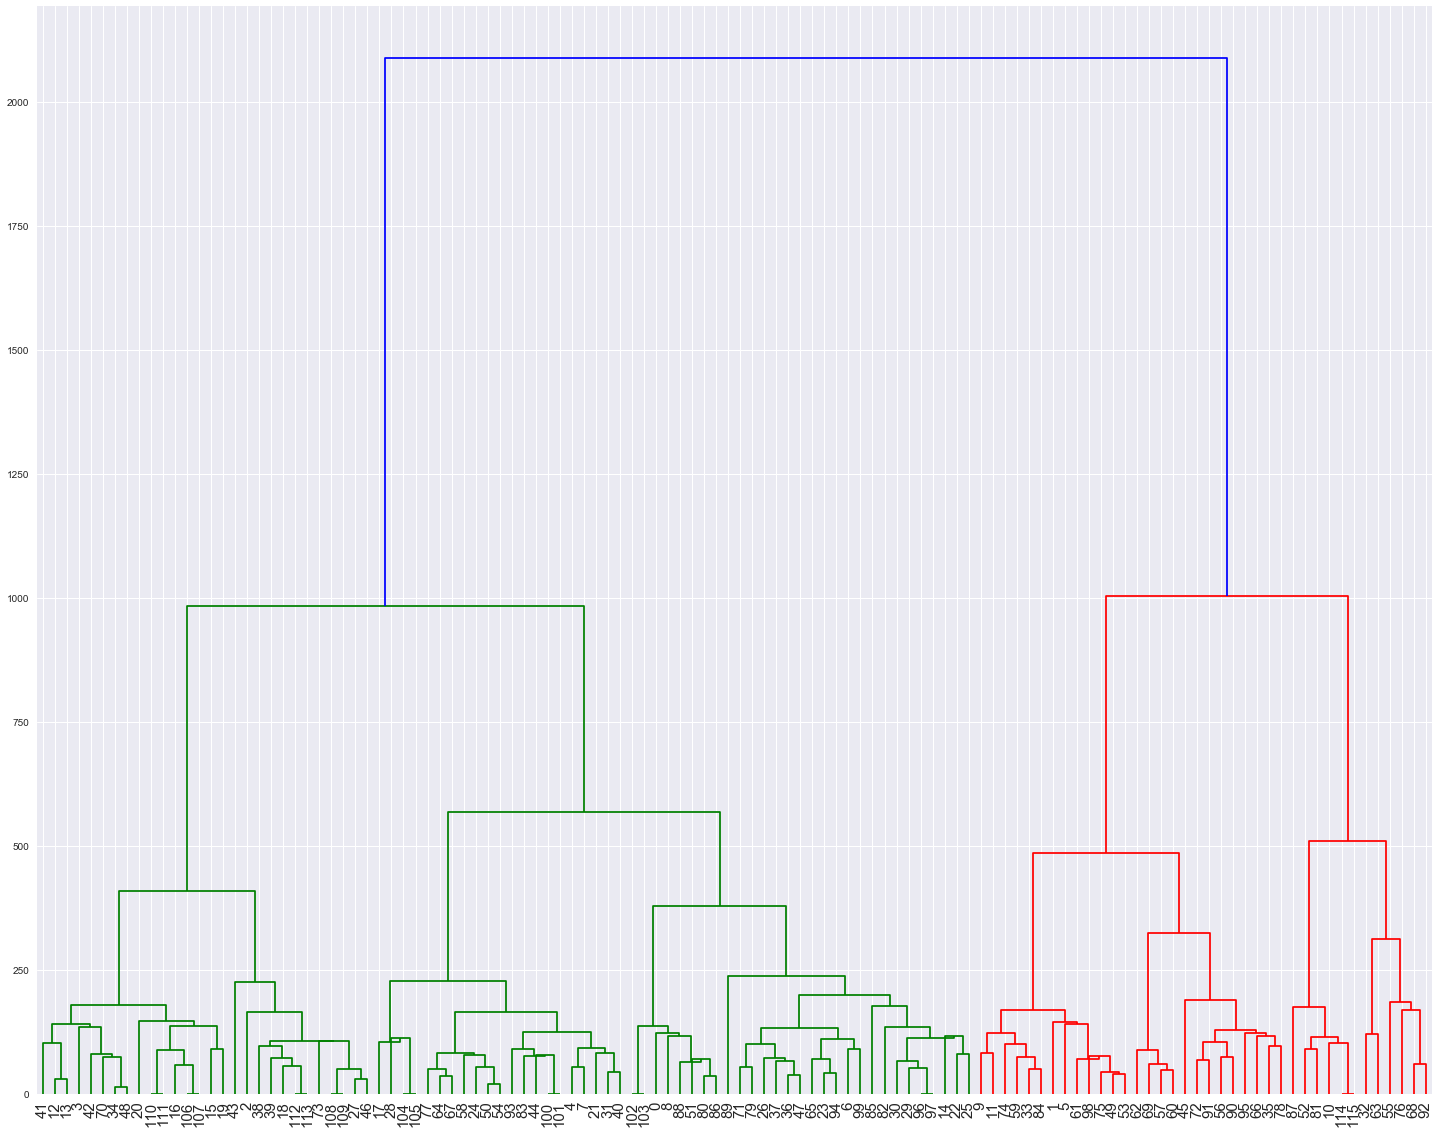

In [214]:
plt.figure(figsize=(25,20))
dn = dendrogram(Cluster)
plt.xticks(size=15)

#### Select only RGCs

In [48]:
RGCs = df[df.Identity == 1]

(array([  5,  15,  25,  35,  45,  55,  65,  75,  85,  95, 105, 115, 125,
        135, 145, 155, 165, 175, 185, 195, 205, 215, 225, 235, 245, 255,
        265, 275, 285, 295, 305, 315, 325, 335, 345, 355, 365, 375, 385,
        395, 405, 415, 425, 435, 445, 455, 465, 475, 485, 495, 505, 515,
        525, 535, 545, 555, 565, 575, 585, 595, 605, 615, 625, 635, 645,
        655, 665, 675, 685, 695, 705, 715, 725, 735, 745, 755, 765, 775,
        785, 795, 805, 815, 825, 835, 845, 855, 865, 875, 885]),
 <a list of 89 Text xticklabel objects>)

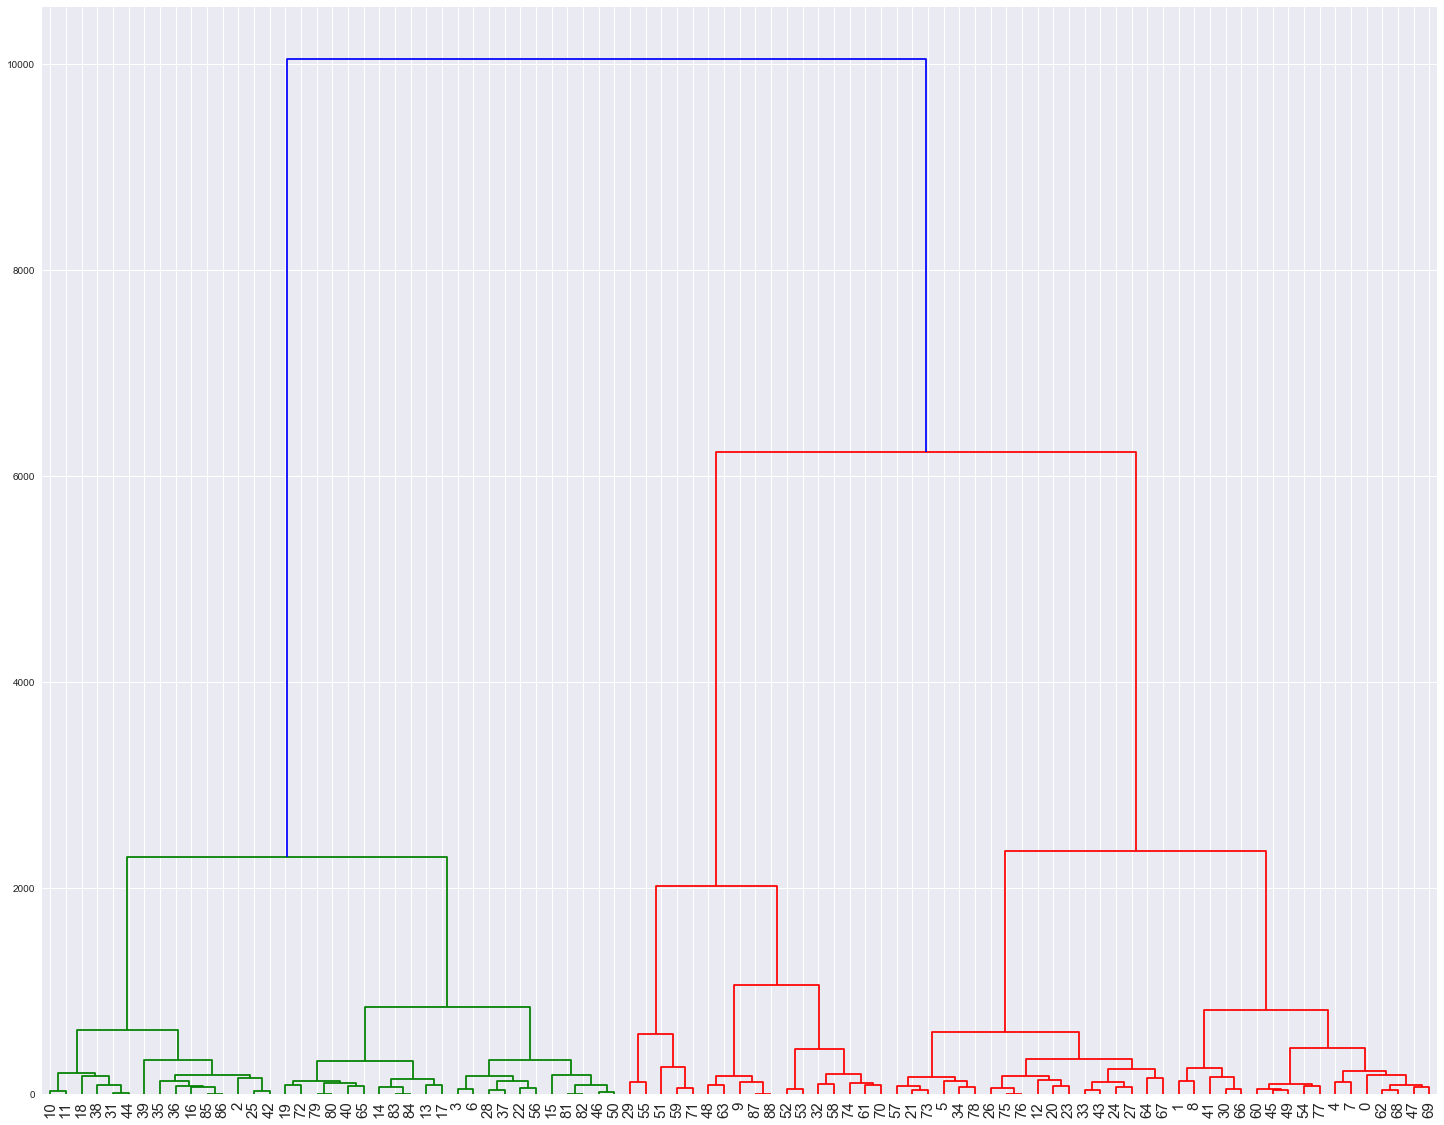

In [50]:
Cluster_RGC = linkage(RGCs, 'ward')
plt.figure(figsize=(25,20))
dn = dendrogram(Cluster_RGC, truncate_mode = 'level', p=20)
plt.xticks(size=15)

In [69]:
Amacrines_select = Amacrines.drop(['Filename1', 'Genotype', 'Sub_Type', 'Age'], axis=1)

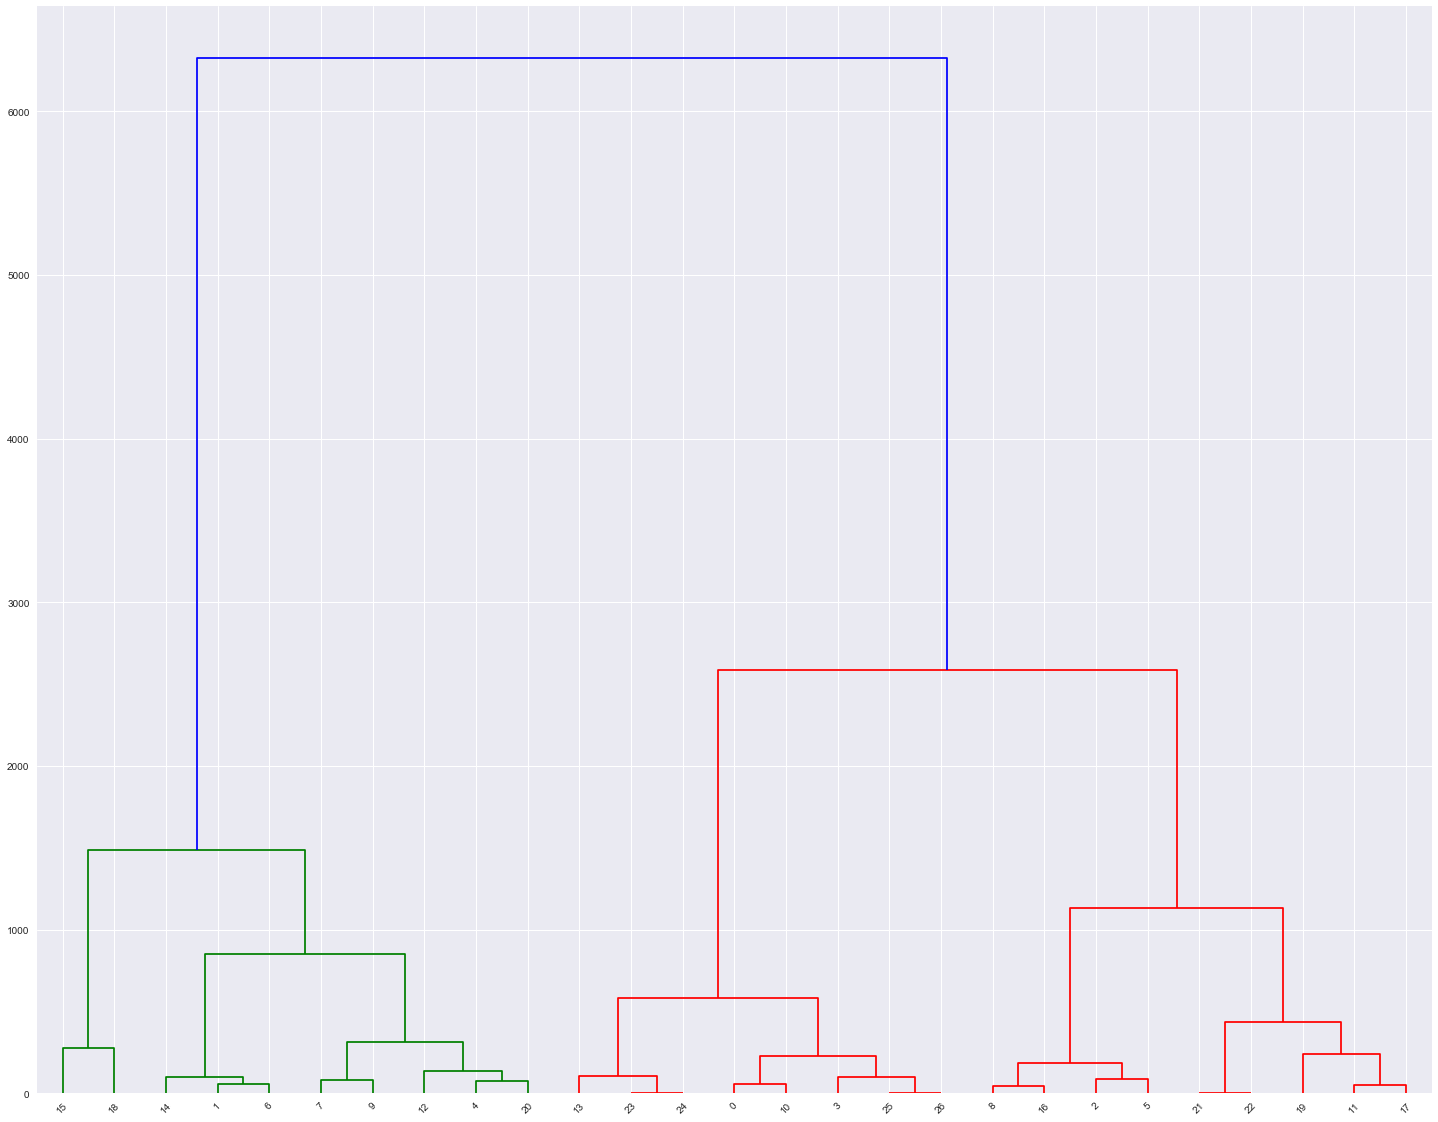

In [83]:
Cluster_Amacrine = linkage(Amacrines_select, 'ward')
plt.figure(figsize=(25,20))
dn = dendrogram(Cluster_Amacrine, truncate_mode = 'level', p=20)

#### t-distributed stochastic neighbour embedding plot to visualize high-dimensional data

In [87]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

#### Scale the features using StandardScaler

In [121]:
tsne_select_df = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=300000).fit_transform(select_df)


[t-SNE] Computing pairwise distances...
[t-SNE] Computing 134 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 135 / 135
[t-SNE] Mean sigma: 1055.393765
[t-SNE] KL divergence after 75 iterations with early exaggeration: 1.024008
[t-SNE] Error after 100 iterations: 1.024008


In [122]:
tsne_select_df

array([[ -59.25754384,   15.63363108],
       [ -26.86295947,  -22.27291301],
       [  48.01756101,  -35.80432535],
       [  11.37199663,   -0.69799053],
       [  72.6931401 ,    4.76787691],
       [ -44.6345754 ,    6.47667711],
       [  46.2962055 ,    4.2178351 ],
       [  26.54534812,  -23.17958767],
       [  61.7254415 ,   -9.11539   ],
       [ -79.21215963,  -25.81005245],
       [ -12.35642649,  -49.97565106],
       [  34.15538964,    6.02036296],
       [  -6.93923867,  -63.2526869 ],
       [  34.51014862,   26.4794442 ],
       [  52.17583711,   40.65209443],
       [ -52.65052987,  -35.99564512],
       [   3.88615166,  -21.98260075],
       [   4.4968125 ,   23.37338881],
       [  53.04652297,  -47.97876798],
       [  92.44892831,  -13.82436491],
       [  -6.39160478,   -7.77001989],
       [   4.19587678,   -9.38612064],
       [  21.70713049,    6.9811055 ],
       [  -7.3471268 ,  -18.41619171],
       [ -83.09455098,   -1.21412493],
       [ -71.0753499 ,  -

In [123]:
tsne_select_df.shape

(135, 2)

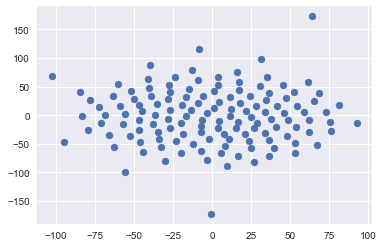

In [124]:
plt.figure()
plt.scatter(tsne_select_df[:,0],tsne_select_df[:,1])

In [ ]:
# Use PCA to find most important components
# Use clustering algorithm to cluster cells based on most important values